### Grafo

In [1]:
import pandas as pd
import glob
import pickle
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import itertools

path_tablas_intermedias = "../../Codigo/data_output/graph/"


path = "../../Codigo/data_output/match_sensor_edge/"
path_graph='../data_output/graph/graph.pickle'
path_pd_edges='../data_output/graph/graph_edges.csv'

path_save_dual_nodes = path_tablas_intermedias+"pd_nodes_dual.csv"  
path_save_dual_edges = path_tablas_intermedias+"pd_edges_dual.csv"
path_id_sensor_selected = "../data_output/pd_id_sensor_selected.csv"

C:\Users\Usuario\anaconda3\envs\ox\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
pd_sensor=pd.DataFrame()
pd_sensor_selected = pd.read_csv(path_id_sensor_selected)

for i in glob.glob(path+"*.csv"):
    df = pd.read_csv(str(i)).drop(['Unnamed: 0'], axis=1)
    pd_sensor = pd.concat([df, pd_sensor],axis=0)
print(pd_sensor.shape)

pd_sensor.merge(pd_sensor_selected, left_on=['id'], right_on=['id_selected'], how='inner').shape

(4373, 12)


(1535, 14)

In [4]:

def join_all_files(path, path_id_sensor_selected):

    pd_sensor=pd.DataFrame()
    pd_sensor_selected = pd.read_csv(path_id_sensor_selected)
    
    for i in glob.glob(path+"*.csv"):

        df = pd.read_csv(str(i)).drop(['Unnamed: 0'], axis=1)
        pd_sensor = pd.concat([df, pd_sensor],axis=0)

    pd_sensor = pd_sensor.drop(['Unnamed: 0.1'],axis=1)    
    pd_sensor['u'] = pd_sensor['from_to_graph'].apply(lambda x: eval(x)[0])
    pd_sensor['v'] = pd_sensor['from_to_graph'].apply(lambda x: eval(x)[1])
    pd_sensor['uv'] = pd_sensor['from_to_graph'].apply(lambda x: (eval(x)[0], eval(x)[1]))
    pd_sensor['distance'] = pd_sensor['from_to_graph'].apply(lambda x: eval(x)[2])
    pd_sensor = pd_sensor.drop(['from_to_graph', 'distance'], axis=1)
    pd_sensor['sensor']=True
    print(pd_sensor.drop_duplicates().shape, pd_sensor.shape)
    pd_sensor_selected = pd_sensor.merge(pd_sensor_selected, left_on=['id'], right_on=['id_selected'], how='inner')
    return pd_sensor_selected


def read_pd_edges_graph(path_pd_edges):

    pd_edges= pd.read_csv(path_pd_edges).drop_duplicates()
    pd_edges['name_node']=['X'+str(i) for i in range(pd_edges.shape[0])]
    pd_edges['pd_edges']=True
    pd_edges = pd_edges[(pd_edges["name_node"].str.contains('X', na=True))]
    
    return pd_edges

def join_pd_edges_sensor(pd_edges, pd_sensor): 
    
    pd_edges_f= pd_edges.merge(pd_sensor, on=['u','v'],how='left')
    pd_edges_f = pd_edges_f[(pd_edges_f["name_node"].str.contains('X', na=True))]
    return pd_edges_f



def convert_to_dual_graph(path, path_id_sensor_selected, path_pd_edges):
    
    print("== Uniendo todos los ficheros de sensores")
    pd_sensor=join_all_files(path, path_id_sensor_selected)
    print(pd_sensor.shape)
    print("== Leyendo dataset final de sensores")
    pd_edges = read_pd_edges_graph(path_pd_edges)
    print("== Leyendo dataset final de sensores")
    pd_edges_f = join_pd_edges_sensor(pd_edges, pd_sensor)
    print(pd_edges_f.shape)
    print("== Convirtiendo a dual el grafo original")
    pd_edges_dual = pd.DataFrame()
    pd_edges_dual['from']=list(range(pd_edges_f.shape[0]))
    pd_edges_dual['to']=list(range(pd_edges_f.shape[0]))
    pd_edges_dual['length']=None
    pd_edges_dual['id']=None
    pd_edges_dual['sensor']=None
    print(pd_edges_f.columns)
    for i in range(pd_edges.shape[0]):

        pd_edges_dual['from'].iloc[i]=pd_edges_f['name_node'].iloc[i]
        pd_edges_dual['to'].iloc[i]=str(list(pd_edges_f['name_node'][pd_edges_f['u']==pd_edges_f['v'].iloc[i]].values))
        pd_edges_dual['length'].iloc[i] = pd_edges_f['length'].iloc[i]
        pd_edges_dual['id'].iloc[i] = pd_edges_f['id'].iloc[i]
        pd_edges_dual['sensor'].iloc[i] = pd_edges_f['sensor'].iloc[i]
        
    pd_edges_dual = pd_edges_dual[(pd_edges_dual["from"].str.contains('X', na=False))]
    print("== Operaciones para hacer explode a la tabla de aristas")
    # print(pd_edges_dual['to'].head())
    pd_edges_dual['to'] = pd_edges_dual['to'].apply(lambda x: eval(x))
    pd_edges_dual_final = pd_edges_dual.explode('to').drop_duplicates()
    pd_nodes_dual_final = pd_edges.copy()
    
    return pd_edges_dual_final, pd_nodes_dual_final


def proc_save_dual_graph_nodes_edges(path, path_pd_edges, path_save_dual_nodes, path_save_dual_edges):
    
    pd_edges_dual_final, pd_nodes_dual_final = convert_to_dual_graph(path, path_id_sensor_selected, path_pd_edges)
    pd_nodes_dual_final.to_csv(path_save_dual_nodes)
    pd_edges_dual_final.to_csv(path_save_dual_edges)
    
    return pd_edges_dual_final, pd_nodes_dual_final
    
pd_edges_dual_final, pd_nodes_dual_final = proc_save_dual_graph_nodes_edges(path, path_pd_edges, 
                                                                            path_save_dual_nodes, path_save_dual_edges)
# pd_sensor.head(2)

== Uniendo todos los ficheros de sensores
(4373, 14) (4373, 14)
(1535, 16)
== Leyendo dataset final de sensores


C:\Users\Usuario\AppData\Local\Temp/ipykernel_7720/1077262688.py:46: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  pd_edges = read_pd_edges_graph(path_pd_edges)


== Leyendo dataset final de sensores
(195238, 35)
== Convirtiendo a dual el grafo original
Index(['u', 'v', 'key', 'osmid', 'oneway', 'lanes', 'name', 'highway',
       'maxspeed', 'length', 'ref', 'junction', 'bridge', 'access', 'tunnel',
       'est_width', 'landuse', 'width', 'geometry', 'name_node', 'pd_edges',
       'tipo_elem', 'distrito', 'id', 'cod_cent', 'nombre', 'utm_x', 'utm_y',
       'longitud', 'latitud', 'random_col', 'uv', 'sensor', 'Unnamed: 0',
       'id_selected'],
      dtype='object')


C:\Users\Usuario\anaconda3\envs\ox\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


== Operaciones para hacer explode a la tabla de aristas


In [5]:
pd_edges_dual_final[pd_edges_dual_final['sensor']==True].shape

(2199, 5)

### Algoritmo de eliminación de nodos

[(10, {20: {'weight': 1}}), (20, {30: {'weight': 1}, 80: {'weight': 1}, 1: {'weight': 1}}), (11, {20: {'weight': 1}}), (30, {40: {'weight': 1}}), (80, {}), (1, {}), (40, {})]
=============== 20 ===============
20 [(10, {30: {'weight': 2}, 80: {'weight': 2}, 1: {'weight': 2}}), (11, {30: {'weight': 2}, 80: {'weight': 2}, 1: {'weight': 2}}), (30, {40: {'weight': 1}}), (80, {}), (1, {}), (40, {})]
=============== 30 ===============
30 [(10, {80: {'weight': 2}, 1: {'weight': 2}, 40: {'weight': 3}}), (11, {80: {'weight': 2}, 1: {'weight': 2}, 40: {'weight': 3}}), (80, {}), (1, {}), (40, {})]


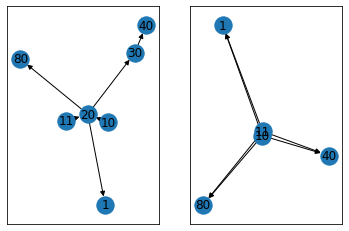

In [6]:

def remove_node(g, node):
    
    if g.is_directed():
        sources = [source for source, _ in g.in_edges(node)]
        targets = [target for _, target in g.out_edges(node)]
    else:
        sources = g.neighbors(node)
        targets = g.neighbors(node)

    new_edges = itertools.product(sources, targets)
    last_edges = itertools.product(sources, [node])
    last_weights = [(u, v, g[u][v]['weight']) for (u, v) in last_edges]
    target_edges = itertools.product([node], targets)
    target_weights = [(u, v, g[u][v]['weight']) for (u, v) in target_edges]
    
    weights = []
    #if len(last_weights)!=0:
    for i in range(len(last_weights)):
        for j in range(len(target_weights)):
            if (last_weights[i][1]==target_weights[j][0]):
                weights.append((last_weights[i][0], target_weights[j][1], 
                                    last_weights[i][2]+target_weights[j][2]))

    new_edges = [(source, target) for source, target in new_edges if source != target] # remove self-loops

    g.add_edges_from(new_edges)
    g.remove_node(node)
    list_edges = [e for e in g.edges()]
    list_edges_weight = [(e[0], e[1]) for e in weights]
    set_list_edges = list(set(list_edges)-set(list_edges_weight))
    list_weights_set_list_edges = [(u, v, g[u][v]['weight']) for (u, v) in set_list_edges if nx.is_weighted(g, (u, v))]
    final_weights = weights+list_weights_set_list_edges

    g.add_weighted_edges_from(final_weights)

    return g



In [ ]:
## Ejemplo sobre un grafo sencillo

edges = [(10, 20), (11,20),(20, 30), (20, 80),(20,1),(30, 40)]
g = nx.DiGraph()
g.add_edges_from(edges)
nx.set_edge_attributes(g, values = 1, name = 'weight')

fig, (ax1, ax2) = plt.subplots(1, 2)  
nx.draw_networkx(g, with_labels=True, ax=ax1)


nx.set_edge_attributes(g, values = 1, name = 'weight')
print(list(g.adjacency()))
print("=============== 20 ===============")
g = remove_node(g, 20)
print('20',list(g.adjacency()))
print("=============== 30 ===============")
g = remove_node(g, 30)
print('30',list(g.adjacency()))
nx.draw_networkx(g, with_labels=True, ax=ax2)
plt.show()

In [7]:
list(g.adjacency())

[(10, {80: {'weight': 2}, 1: {'weight': 2}, 40: {'weight': 3}}),
 (11, {80: {'weight': 2}, 1: {'weight': 2}, 40: {'weight': 3}}),
 (80, {}),
 (1, {}),
 (40, {})]

### Algoritmo de Dijsktra para encontrar el camino mínimo

In [ ]:
%%time
import itertools
import networkx as nx

list_sensor= list(pd_edges_dual_final['from'][pd_edges_dual_final['sensor']==True].unique())
list_sensor
result = list(itertools.product(list_sensor,list_sensor))
print(len(result))
pd_path_sensor = pd.read_csv('pd_path_sensor_shortest2_path_935000.csv')

j=0
for i in result:
    if j%5000==0:
        print(j)
        pd_path_sensor.to_csv('pd_path_sensor_shortest2_path_'+str(j)+'.csv')
    pd_path_sensor.loc[j,'from']=i[0]
    pd_path_sensor.loc[j, 'to']=i[1]
    pd_path_sensor.loc[j, 'shortest_path'] = str(nx.single_source_dijkstra(g_ini, source=i[0], target=i[1]))
    j=j+1
    

2196324
935000
940000
945000
950000
955000
960000
965000
970000
975000
980000
985000
990000
995000
1000000
1005000
1010000
1015000
1020000
1025000
1030000
1035000
1040000
1045000
1050000
1055000
1060000
1065000
1070000
1075000
1080000
1085000
